<a href="https://colab.research.google.com/github/sahar-mariam/kannada-sentiment-analysis/blob/main/XLM_R_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# loading the dataset
file_path = "/content/balanced_dataset.csv"  # add colab path for dataset
data = pd.read_csv(file_path)

# displaying dataset info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3885 entries, 0 to 3884
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   textID             3885 non-null   object 
 1   text               3885 non-null   object 
 2   sentiment          3885 non-null   object 
 3   Time of Tweet      3885 non-null   object 
 4   Age of User        3885 non-null   object 
 5   Country            3885 non-null   object 
 6   Population -2020   3885 non-null   float64
 7   Land Area (Km²)    3885 non-null   float64
 8   Density (P/Km²)    3885 non-null   float64
 9   sentiment_numeric  3885 non-null   int64  
dtypes: float64(3), int64(1), object(6)
memory usage: 303.6+ KB
None
       textID                                               text sentiment  \
0  c5ec3e9e37  ನಾನಿನ್ನೂ ಅಲ್ಲ. ನಾನು RR ಮತ್ತು ನನ್ನ ಬಿಯರ್ ಅನ್ನು ...     ತಟಸ್ಥ   
1  2a5bb8d827  ಬಿ-ಡೇ ಶುಭಾಶಯಗಳು! ಭೂಮಿಯ ಈ ಭಾಗದಲ್ಲಿ ಈಗಷ್ಟೇ ಎಚ್ಚರ...   ಧನಾತ್ಮಕ   
2  02b43cd23c 

In [8]:
# splitting the data into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['text'], data['sentiment_numeric'], test_size=0.2, random_state=42, stratify=data['sentiment_numeric']
)

# wrapping data into Hugging Face Dataset format
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels.tolist()})

# loading tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

# tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Map:   0%|          | 0/3108 [00:00<?, ? examples/s]

Map:   0%|          | 0/777 [00:00<?, ? examples/s]

In [9]:
# loading pre-trained XLM-R model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

# defining training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

# defining Trainer
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    labels = pred.label_ids
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# training the model
trainer.train()


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.836100,0.796406,0.687259,0.682217
2,0.660500,0.657544,0.728443,0.727512
3,0.744800,0.668466,0.736165,0.732087


TrainOutput(global_step=585, training_loss=0.7882070912255181, metrics={'train_runtime': 1063.1128, 'train_samples_per_second': 8.77, 'train_steps_per_second': 0.55, 'total_flos': 2453269506895872.0, 'train_loss': 0.7882070912255181, 'epoch': 3.0})

In [10]:
# evaluating on test dataset
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# classification report
print("\nClassification Report:")
print(classification_report(test_labels, preds, target_names=["Negative", "Neutral", "Positive"]))



Classification Report:
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76       259
     Neutral       0.65      0.62      0.63       259
    Positive       0.77      0.80      0.78       259

    accuracy                           0.73       777
   macro avg       0.73      0.73      0.73       777
weighted avg       0.73      0.73      0.73       777




Confusion Matrix:
[[199  52   8]
 [ 46 161  52]
 [ 17  36 206]]


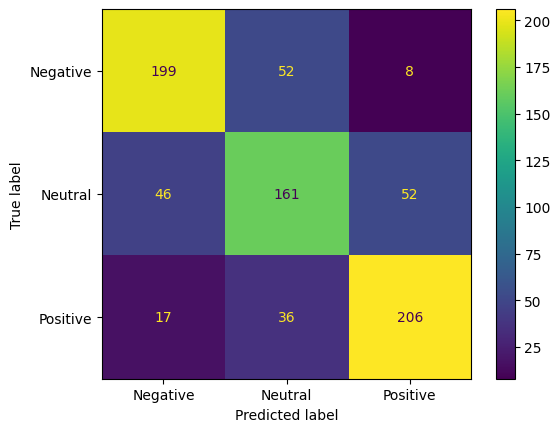

In [11]:
# confusion matrix
cm = confusion_matrix(test_labels, preds)
print("\nConfusion Matrix:")
print(cm)


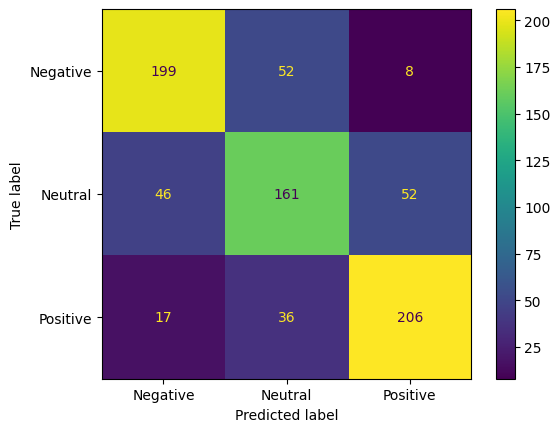

In [12]:
# plot confusion matrix
ConfusionMatrixDisplay.from_predictions(test_labels, preds, display_labels=["Negative", "Neutral", "Positive"])
plt.show()

In [13]:
#inference

import torch

def predict_sentiment_xlmr(text, model, tokenizer):
    """
    Predicting the sentiment of the input text using the trained XLM-R model.
    Args:
    - text (str): The input text in Kannada.
    - model: The trained Hugging Face XLM-R model.
    - tokenizer: The tokenizer used for preprocessing.

    Returns:
    - sentiment (str): Predicted sentiment (Negative, Neutral, Positive).
    - confidence (float): Confidence score of the prediction.
    """
    # moving model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # preprocessing the text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    # performing inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # getting the predicted class and confidence
    predicted_class = torch.argmax(probabilities).item()
    confidence = probabilities[0][predicted_class].item()

    # mapping numeric labels to sentiment
    label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    sentiment = label_map[predicted_class]

    return sentiment, confidence

# taking user input
user_input = input("Enter a Kannada text: ")

# predicting sentiment
predicted_sentiment, confidence_score = predict_sentiment_xlmr(user_input, model, tokenizer)

# displaying result
print(f"Predicted Sentiment: {predicted_sentiment}")
print(f"Confidence Score: {confidence_score:.2f}")


Enter a Kannada text: ನನಗೆ ಕೆಲಸ ಸಿಕ್ಕಿತು
Predicted Sentiment: Neutral
Confidence Score: 0.73
